In [31]:
import torch,os
import torchvision.transforms as transforms
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import matplotlib

In [9]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 2000

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
use_cuda = torch.cuda.is_available()
softmax=torch.nn.Softmax()

In [10]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)

In [11]:
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


In [12]:
max_epochs=50
learning_rate=0.1
optimizer = torch.optim.Adam(vae.parameters())
for epoch in range(max_epochs):
    for pts in range(train_loader.batch_size):
        optimizer.zero_grad()
        x=torch.flatten(train_loader.dataset[pts][0])
        recon_x,mu,log_var=vae.forward(x)
        loss=loss_function(recon_x,x,mu,log_var)
        loss.backward()
        optimizer.step()

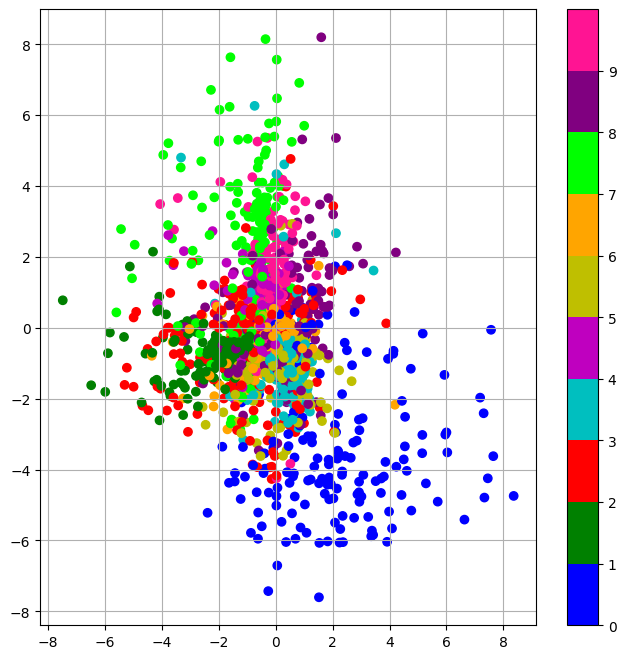

In [43]:
encoded_x=[]
for i in range(test_loader.batch_size):
    encoded_x.append(vae.encoder(torch.flatten(test_loader.dataset[i][0]))[0].detach().numpy())
colors=['b','g','r','c','m','y','orange','lime','purple','deeppink']
encoded_x=np.array(encoded_x)
x=encoded_x[:,0]
y=encoded_x[:,1]
labels=[]
classes=[0,1,2,3,4,5,6,7,8,9]
for i in range(test_loader.batch_size):
    labels.append(test_loader.dataset[i][1])
fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
plt.grid()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(classes)


c:\Users\prana\OneDrive\Desktop\IITHyderabad\codes\DL\Assign3\env\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


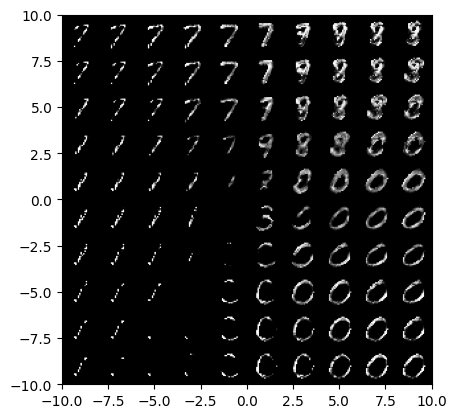

In [49]:
r0=(-10, 10)
r1=(-10, 10) 
w = 28
n=10
img = np.zeros((n*w, n*w))
for i, y in enumerate(np.linspace(*r1, n)):
    for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.Tensor([[x, y]])
        x_hat=vae.decoder(z).detach().numpy()
        x_hat=np.reshape(x_hat,(28,28))
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
plt.imshow(img, extent=[*r0, *r1],cmap='Greys_r')